# Controller-Observer System for Spacecraft with Reaction Wheels

This Jupyter Notebook contains code to design and implement a controller-observer system for a spacecraft with 4 reaction wheels and a star tracker.

In [1]:
import time
import numpy as np
import sympy as sym
from scipy import linalg, signal
import matplotlib.pyplot as plt
import ae353_spacecraft

## Dynamic Model and Controller

**Equations of Motion**

The following code block derives the equations of motion for the system using physical parameters and equations from ```DeriveEOM.ipynb``` and provides a symbolic matrix ```f``` which is used to linearize the system.

In [2]:
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

# roll, pitch, yaw angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# parameters
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)
f

Matrix([
[                        (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                                     w_x*sin(psi) + w_y*cos(psi)],
[        -w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                -55*sqrt(2)*(tau_1 + tau_2 + tau_3 + tau_4)/2084]])

**Linearizing the Dynamic Model - Finding ```A``` and ```B``` Matrices**

The following code block contains selected equilibrium conditions for the state and input variables and linearizes the system to provide the state matrix ```A``` and the input matrix ```B``` (both printed). Equilibrium values for the state and input are also stored in ```m_e``` and ```n_e``` respectively such that they can be used in the controller later, although this is not technically necessary when all such values are zero. A commented section also allows printing a matrix to demonstrate that the selected values of equilibrium satisfy the model.

In [3]:
# Equilibrium points
phi_e = 0.
theta_e = 0.
psi_e = 0.
w_x_e = 0.
w_y_e = 0.
w_z_e = 0.
tau_1_e = 0.
tau_2_e = 0.
tau_3_e = 0.
tau_4_e = 0.

# Verify equilibrium
# F_num = sym.lambdify((phi, theta, psi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4), f)
# F = F_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)
# print(F)

# A matrix
A_num = sym.lambdify((phi, theta, psi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4), f.jacobian([phi, theta, psi, w_x, w_y, w_z]))
A = A_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)
print('\nState Matrix (A)\n')
print(A)

# B matrix
B_num = sym.lambdify((phi, theta, psi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4), f.jacobian([tau_1, tau_2, tau_3, tau_4]))
B = B_num(phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)
print('\nInput Matrix (B)\n')
print(B)

# Equilibrium for state
m_e = np.array([[phi_e], [theta_e], [psi_e], [w_x_e], [w_y_e], [w_z_e]])

# Equilibrium for input
n_e = np.array([[tau_1_e], [tau_2_e], [tau_3_e], [tau_4_e]])


State Matrix (A)

[[ 0.  0. -0.  1. -0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0. -0.  0.  1.]
 [ 0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]

Input Matrix (B)

[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.05241358  0.05241358  0.          0.        ]
 [ 0.          0.         -0.05241358  0.05241358]
 [-0.03732329 -0.03732329 -0.03732329 -0.03732329]]


**Controllability**

The system as linearized is controllable if the controllability matrix ```W``` calculated using ```A``` and ```B``` are full rank. In this case, the rank printed is 6, which satisfies this requirement, and thus the linearized system is controllable.

In [4]:
mp = np.linalg.matrix_power
n = A.shape[0]
W = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
rank = np.linalg.matrix_rank(W)
print('\nRank for controllability matrix (W): {}\n'.format(rank))
print(W)


Rank for controllability matrix (W): 6

[[ 0.          0.          0.          0.         -0.05241358  0.05241358
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.05241358  0.05241358  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.03732329 -0.03732329
  -0.03732329 -0.03732329  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.05241358  0.05241358  0.          0.          0.          0.
   0.          0.          0.          0.          0.     

**Optimal Controller Design - Finding Matrix ```K```**

We use a linear-quadratic regulator method to find a gain matrix ```K``` for the controller. ```Q_c``` and ```R_c``` describe "weighting" of the state and input variables, respectively. ```linalg.solve_continuous_are()``` solves the infinite horizon LQR problem to find an optimal controller. The resulting gain matrix ```K``` is printed.

In [5]:
Q_c = np.diag([2500, 2500, 2500, 1, 1, 1])
R_c = np.eye(4)
P = linalg.solve_continuous_are(A, B, Q_c, R_c)
K = linalg.inv(R_c) @  B.T @ P
print('\nGain Matrix (K)\n')
print(K)


Gain Matrix (K)

[[-3.53553391e+01  3.71872905e-14 -2.50000000e+01 -2.59816369e+01
   2.05551718e-14 -1.83074161e+01]
 [ 3.53553391e+01  4.77692004e-14 -2.50000000e+01  2.59816369e+01
   1.67936485e-14 -1.83074161e+01]
 [ 9.54724298e-15 -3.53553391e+01 -2.50000000e+01  6.76242741e-15
  -2.59816369e+01 -1.83074161e+01]
 [-4.66489286e-15  3.53553391e+01 -2.50000000e+01  3.00090411e-15
   2.59816369e+01 -1.83074161e+01]]


## Sensor Model and Observer

**Sensor Model Equations**

The following code block describes the sensor model for the system. We are provided with a model relating y and z coordinates for a star to its right ascension and declination as well as the orientation of the spacecraft. In order to model all 3 stars in the default project configuration, a model is created for each star and its respective right ascension and declination.

In [6]:
alpha_1, alpha_2, alpha_3, delta_1, delta_2, delta_3 = sym.symbols('alpha_1, alpha_2, alpha_3, delta_1, delta_2, delta_3')
alpha_list = [alpha_1, alpha_2, alpha_3]
delta_list = [delta_1, delta_2, delta_3]

# Scope radius
r = 0.8 / 2.1

# Position of star in space frame
g_list = []
for i in range(0, 3):
    alpha = alpha_list[i]
    delta = delta_list[i]
    p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                                  [sym.sin(alpha) * sym.cos(delta)],
                                  [sym.sin(delta)]])

    # Orientation of body frame in space frame
    R_body_in_space = Rx * Ry * Rz

    # Position of star in body frame (assuming origin of body and space frames are the same)
    p_star_in_body = R_body_in_space.T * p_star_in_space

    # Position of star in image frame
    p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                           [p_star_in_body[2] / p_star_in_body[0]]])

    # Sensor model for each star
    g_list.append(sym.simplify(p_star_in_image, full=True))

g = sym.Matrix([[g_list[0]], [g_list[1]], [g_list[2]]])
g

Matrix([
[21*((sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*sin(delta_1) - (sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*sin(alpha_1)*cos(delta_1) - sin(psi)*cos(alpha_1)*cos(delta_1)*cos(theta))/(8*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*sin(delta_1) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*sin(alpha_1)*cos(delta_1) + cos(alpha_1)*cos(delta_1)*cos(psi)*cos(theta)))],
[                                                                      21*(-sin(alpha_1)*sin(phi)*cos(delta_1)*cos(theta) + sin(delta_1)*cos(phi)*cos(theta) + sin(theta)*cos(alpha_1)*cos(delta_1))/(8*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*sin(delta_1) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*sin(alpha_1)*cos(delta_1) + cos(alpha_1)*cos(delta_1)*cos(psi)*cos(theta)))],
[21*((sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*sin(delta_2) - (sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*sin(alpha_2)*cos(delta_2) - sin(psi)*cos(alpha_2)*cos(delta_2)*cos(theta))/(8

**Linearizing Sensor Model for 3 Stars - Finding Matrix ```C```**

The next code block linearizes the sensor model for the case where all 3 stars are visible to the star tracker. The known right ascension and declination values for each star are substituted into a combined matrix ```g``` consisting of 6 equations, 2 for each star (y and z). The ```C``` matrix is found by taking the Jacobian of ```g``` with respect to the state, and ```g_e``` represents the expected sensor measurements at equilibrium. ```C``` is later used for the observer, and ```g_e``` is used to find the output ```y```, both in the controller class. Both are printed.

In [7]:
# C matrix for 3 stars
g = sym.Matrix([[g_list[0]], [g_list[1]], [g_list[2]]])
g = g.subs([(alpha_1, 0.), (alpha_2, 0.15), (alpha_3, 0.), (delta_1, 0.), (delta_2, 0.), (delta_3, 0.15)])

# Find expected sensor measurements, g_e, at equilibrium
G_num = sym.lambdify((phi, theta, psi), g)
G = G_num(phi_e, theta_e, psi_e)
print('\nExpected Sensor Measurements (g_e)\n')
print(G)
g_e = G

# Take Jacobian to find C
C_num = sym.lambdify((phi, theta, psi), g.jacobian([phi, theta, psi, w_x, w_y, w_z]))
C = C_num(phi_e, theta_e, psi_e).astype(float)
print('\nState-Output Coefficient Matrix (C)\n')
print(C)


Expected Sensor Measurements (g_e)

[[-0.        ]
 [ 0.        ]
 [ 0.39672995]
 [ 0.        ]
 [ 0.        ]
 [ 0.39672995]]

State-Output Coefficient Matrix (C)

[[ 0.          0.         -2.625       0.          0.          0.        ]
 [ 0.          2.625       0.          0.          0.          0.        ]
 [ 0.          0.         -2.68495987  0.          0.          0.        ]
 [-0.39672995  2.625      -0.          0.          0.          0.        ]
 [ 0.39672995  0.         -2.625       0.          0.          0.        ]
 [-0.          2.68495987  0.          0.          0.          0.        ]]


**Linearizing Sensor Model for 2 Stars - Finding ```C``` Matrices**

The system can also be linearized (and later demonstrated to be observable) when only 2 stars are visible to the star tracker. The same steps are followed as for 3 stars, but there are only 4 equations in the symbolic ```g``` matrix. Variables are named according to the stars which they model; for example, ```C12``` refers to the ```C``` matrix for when only stars 1 and 2 are visible. There are three code blocks below, since there are three possible combinations of 2 stars for a system of 3 stars.

In [8]:
# C matrix for stars 1 and 2
g12 = sym.Matrix([[g_list[0]], [g_list[1]]])
g12 = g12.subs([(alpha_1, 0.), (alpha_2, 0.15), (delta_1, 0.), (delta_2, 0.)])

G12_num = sym.lambdify((phi, theta, psi), g12)
G12 = G12_num(phi_e, theta_e, psi_e)
print('\nExpected Sensor Measurements (g12_e)\n')
print(G12)
g12_e = G12

C12_num = sym.lambdify((phi, theta, psi), g12.jacobian([phi, theta, psi, w_x, w_y, w_z]))
C12 = C12_num(phi_e, theta_e, psi_e).astype(float)
print('\nState-Output Coefficient Matrix (C12)\n')
print(C12)


Expected Sensor Measurements (g12_e)

[[-0.        ]
 [ 0.        ]
 [ 0.39672995]
 [ 0.        ]]

State-Output Coefficient Matrix (C12)

[[ 0.          0.         -2.625       0.          0.          0.        ]
 [ 0.          2.625       0.          0.          0.          0.        ]
 [ 0.          0.         -2.68495987  0.          0.          0.        ]
 [-0.39672995  2.625      -0.          0.          0.          0.        ]]


In [9]:
# C matrix for stars 1 and 3
g13 = sym.Matrix([[g_list[0]], [g_list[2]]])
g13 = g13.subs([(alpha_1, 0.), (alpha_3, 0.), (delta_1, 0.), (delta_3, 0.15)])

G13_num = sym.lambdify((phi, theta, psi), g13)
G13 = G13_num(phi_e, theta_e, psi_e)
print('\nExpected Sensor Measurements (g13_e)\n')
print(G13)
g13_e = G13

C13_num = sym.lambdify((phi, theta, psi), g13.jacobian([phi, theta, psi, w_x, w_y, w_z]))
C13 = C13_num(phi_e, theta_e, psi_e).astype(float)
print('\nState-Output Coefficient Matrix (C13)\n')
print(C13)


Expected Sensor Measurements (g13_e)

[[-0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.39672995]]

State-Output Coefficient Matrix (C13)

[[ 0.          0.         -2.625       0.          0.          0.        ]
 [ 0.          2.625       0.          0.          0.          0.        ]
 [ 0.39672995  0.         -2.625       0.          0.          0.        ]
 [-0.          2.68495987  0.          0.          0.          0.        ]]


In [10]:
# C matrix for stars 2 and 3
g23 = sym.Matrix([[g_list[1]], [g_list[2]]])
g23 = g23.subs([(alpha_2, 0.15), (alpha_3, 0.), (delta_2, 0.), (delta_3, 0.15)])

G23_num = sym.lambdify((phi, theta, psi), g23)
G23 = G23_num(phi_e, theta_e, psi_e)
print('\nExpected Sensor Measurements (g23_e)\n')
print(G23)
g23_e = G23

C23_num = sym.lambdify((phi, theta, psi), g23.jacobian([phi, theta, psi, w_x, w_y, w_z]))
C23 = C23_num(phi_e, theta_e, psi_e).astype(float)
print('\nState-Output Coefficient Matrix (C23)\n')
print(C23)


Expected Sensor Measurements (g23_e)

[[0.39672995]
 [0.        ]
 [0.        ]
 [0.39672995]]

State-Output Coefficient Matrix (C23)

[[ 0.          0.         -2.68495987  0.          0.          0.        ]
 [-0.39672995  2.625      -0.          0.          0.          0.        ]
 [ 0.39672995  0.         -2.625       0.          0.          0.        ]
 [-0.          2.68495987  0.          0.          0.          0.        ]]


**Observability**

The following block checks observability for all sensor models: when all 3 stars are visible, when only stars 1 and 2 are visible, when only stars 1 and 3 are visible, and when only stars 2 and 3 are visible. The printed rank in all instances is 6, which is the same as the smallest dimension of the observability matrix and thus full rank, demonstrating that all are observable.

In [11]:
mp = np.linalg.matrix_power
O = np.block([[C], [C @ A], [C @ mp(A, 2)], [C @ mp(A, 3)], [C @ mp(A, 4)], [C @ mp(A, 5)]])
rank = np.linalg.matrix_rank(O)
print('\nRank for observability matrix (O) for 3 stars: {}\n'.format(rank))
print(O)

O12 = np.block([[C12], [C12 @ A], [C12 @ mp(A, 2)], [C12 @ mp(A, 3)], [C12 @ mp(A, 4)], [C12 @ mp(A, 5)]])
rank = np.linalg.matrix_rank(O12)
print('\nRank for observability matrix (O12) for stars 1 and 2: {}\n'.format(rank))

O13 = np.block([[C13], [C13 @ A], [C13 @ mp(A, 2)], [C13 @ mp(A, 3)], [C13 @ mp(A, 4)], [C13 @ mp(A, 5)]])
rank = np.linalg.matrix_rank(O13)
print('\nRank for observability matrix (O13) for stars 1 and 3: {}\n'.format(rank))

O23 = np.block([[C23], [C23 @ A], [C23 @ mp(A, 2)], [C23 @ mp(A, 3)], [C23 @ mp(A, 4)], [C23 @ mp(A, 5)]])
rank = np.linalg.matrix_rank(O23)
print('\nRank for observability matrix (O23) for stars 2 and 3: {}\n'.format(rank))


Rank for observability matrix (O) for 3 stars: 6

[[ 0.          0.         -2.625       0.          0.          0.        ]
 [ 0.          2.625       0.          0.          0.          0.        ]
 [ 0.          0.         -2.68495987  0.          0.          0.        ]
 [-0.39672995  2.625      -0.          0.          0.          0.        ]
 [ 0.39672995  0.         -2.625       0.          0.          0.        ]
 [-0.          2.68495987  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -2.625     ]
 [ 0.          0.          0.          0.          2.625       0.        ]
 [ 0.          0.          0.          0.          0.         -2.68495987]
 [ 0.          0.          0.         -0.39672995  2.625       0.        ]
 [ 0.          0.          0.          0.39672995  0.         -2.625     ]
 [ 0.          0.          0.          0.          2.68495987  0.        ]
 [ 0.          0.          0.          0.        

**Optimal Observer Design - Finding Matrix ```L```**

The same LQR method as used for the optimal controller is used to find an optimal observer. A similar approach is taken, this time using matrices ```Q_o``` and ```R_o``` for weighting. The observer gain matrix ```L``` is found as a result. As there are 4 different cases for the linearized sensor model, observer gain matrices ```L``` are found for each case. ```L``` itself refers to the case where all 3 stars are visible to the star tracker, and the other matrices are numbered according to the previously established convention. Each such matrix is printed. The dimension of ```Q_o``` is reduced to 4 x 4 instead of 6 x 6 for the case where only 2 stars are visible to the star tracker, as the dimension of the ```C``` matrix is reduced in this scenario as well.

In [12]:
# Weights
Q_o = np.eye(6) * 3
R_o = np.eye(6) * 2

P = linalg.solve_continuous_are(A.T, C.T, linalg.inv(R_o), linalg.inv(Q_o))
L = P @ C.T @ Q_o
print('\nObserver gain matrix (L) for 3 stars\n')
print(L)

# Weight Q_o, but reduced according to dimension of C
Q_o = np.eye(4) * 3

P = linalg.solve_continuous_are(A.T, C12.T, linalg.inv(R_o), linalg.inv(Q_o))
L12 = P @ C12.T @ Q_o
print('\nObserver gain matrix (L12) for stars 1 and 2\n')
print(L12)

P = linalg.solve_continuous_are(A.T, C13.T, linalg.inv(R_o), linalg.inv(Q_o))
L13 = P @ C13.T @ Q_o
print('\nObserver gain matrix (L13) for stars 1 and 3\n')
print(L13)

P = linalg.solve_continuous_are(A.T, C23.T, linalg.inv(R_o), linalg.inv(Q_o))
L23 = P @ C23.T @ Q_o
print('\nObserver gain matrix (L23) for stars 2 and 3\n')
print(L23)


Observer gain matrix (L) for 3 stars

[[-0.70570193  0.70570193 -0.72182147 -1.54563456  1.54563456  0.72182147]
 [-0.03422241  0.85149114 -0.03500411  0.74483473  0.07243401  0.87094078]
 [-0.85149114  0.03422241 -0.87094078 -0.07243401 -0.74483473  0.03500411]
 [-0.31459894  0.31459894 -0.32178497 -0.73992023  0.73992023  0.32178497]
 [-0.01489746  0.71662098 -0.01523774  0.669074    0.03264952  0.73298993]
 [-0.71662098  0.01489746 -0.73298993 -0.03264952 -0.669074    0.01523774]]

Observer gain matrix (L12) for stars 1 and 2

[[ 1.21010825e-16  2.19266335e+00  1.23774936e-16 -2.32430473e+00]
 [ 1.18523538e-16  1.20240586e+00  1.21230835e-16  8.71017210e-01]
 [-1.02560580e+00 -1.18523538e-16 -1.04903254e+00 -1.00234540e-16]
 [ 2.51202014e-16  8.03199933e-01  2.56939934e-16 -9.24591730e-01]
 [ 1.64584402e-16  9.24591730e-01  1.68343815e-16  8.03199933e-01]
 [-8.56191693e-01 -1.87241045e-16 -8.75748699e-01 -2.43138254e-16]]

Observer gain matrix (L13) for stars 1 and 3

[[-2.19266335

**Stability - Eigenvalues**

The following checks the stability of the system as a whole. If all eigenvalues of the block matrix ```F``` as printed have negative real parts, then the system is stable. Complex conjugate pairs indicate oscillation in the system.

In [13]:
F = np.block([[A - B @ K, - B @ K], [np.zeros([6, 6]), A - L @ C]])
p = linalg.eigvals(F)
print('\nEigenvalues for system with 3 stars\n')
print(p.tolist())

F = np.block([[A - B @ K, - B @ K], [np.zeros([6, 6]), A - L12 @ C12]])
p = linalg.eigvals(F)
print('\nEigenvalues for system with stars 1 and 2\n')
print(p.tolist())

F = np.block([[A - B @ K, - B @ K], [np.zeros([6, 6]), A - L13 @ C13]])
p = linalg.eigvals(F)
print('\nEigenvalues for system with stars 1 and 3\n')
print(p.tolist())

F = np.block([[A - B @ K, - B @ K], [np.zeros([6, 6]), A - L23 @ C23]])
p = linalg.eigvals(F)
print('\nEigenvalues for system with stars 2 and 3\n')
print(p.tolist())


Eigenvalues for system with 3 stars

[(-1.3617904838493402+1.360781444249521j), (-1.3617904838493402-1.360781444249521j), (-1.3665861692327468+1.365566439723742j), (-1.3665861692327468-1.365566439723742j), (-1.3617904838493462+1.3607814442495207j), (-1.3617904838493462-1.3607814442495207j), (-0.5998303342435947+0.4494361341965521j), (-0.5998303342435947-0.4494361341965521j), (-5.532467041583241+0j), (-1.0167469876892297+0j), (-5.518281891052517+0j), (-1.016835386322234+0j)]

Eigenvalues for system with stars 1 and 2

[(-1.3617904838493402+1.360781444249521j), (-1.3617904838493402-1.360781444249521j), (-1.3665861692327468+1.365566439723742j), (-1.3665861692327468-1.365566439723742j), (-1.3617904838493462+1.3607814442495207j), (-1.3617904838493462-1.3607814442495207j), (-0.4479295712321127+0.37676908612908194j), (-0.4479295712321127-0.37676908612908194j), (-4.442659717879685+0j), (-1.0263380022368234+0j), (-4.4829775514549866+0j), (-1.025847944456621+0j)]

Eigenvalues for system with st

## Controller Implementation

The controller and observer are implemented as the ```RobotController``` class in the following code block. The ```extended``` variable can be set to ```True``` to enable the controller/observer capable of switching between sensor models or set to ```False``` for the controller/observer using just the sensor model of 3 stars. The observer switches to using just the dynamic model in the event that there is no sensor model for the current situation, such as situations where 0 or 1 stars are in view of the star tracker, or in the case of the non-extended observer, any situation where not all 3 stars are in view. The ```reset()``` function resets the state estimate to zero, and the ```run()``` function is called during the simulation loop to generate commands from the controller.

In [14]:
# Set extended = False for standard observer capable of only 3 stars
# Set extended = True for extended observer capable of either 2 or 3 stars
extended = True

class RobotController:
    def __init__(self, n_e, g_e, A, B, C, K, L, g12_e, g13_e, g23_e, C12, C13, C23, L12, L13, L23, extended=True):
        self.dt = 0.04
        self.n_e = n_e
        self.g_e = g_e
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.g12_e = g12_e
        self.g13_e = g13_e
        self.g23_e = g23_e
        self.C12 = C12
        self.C13 = C13
        self.C23 = C23
        self.L12 = L12
        self.L13 = L13
        self.L23 = L23
        self.extended = extended
        self.reset()
    
    def reset(self):
        self.xhat = np.zeros((6, 1))
    
    def run(self, p, v):
        u = -self.K @ self.xhat
        tau = u + self.n_e
        
        # If using extended observer with sensor models for 2 or 3 stars
        if self.extended:
            # If more than 2 measurements are NaN, i.e. only 1 star visible, sensor model is not used
            if int(sum(np.isnan(p))) > 2:
                sensor = 0.
            # Star 1 not visible
            elif np.isnan(p[0]):
                p = p[np.logical_not(np.isnan(p))]
                y = np.array([p]).T - self.g23_e
                sensor = self.L23 @ (self.C23 @ self.xhat - y)
            # Star 2 not visible
            elif np.isnan(p[2]):
                p = p[np.logical_not(np.isnan(p))]
                y = np.array([p]).T - self.g13_e
                sensor = self.L13 @ (self.C13 @ self.xhat - y)
            # Star 3 not visible
            elif np.isnan(p[4]):
                p = p[np.logical_not(np.isnan(p))]
                y = np.array([p]).T - self.g12_e
                sensor = self.L12 @ (self.C12 @ self.xhat - y)
            # All stars visible
            else:
                y = np.array([p]).T - self.g_e
                sensor = self.L @ (self.C @ self.xhat - y)
        
        # Else using observer with sensor model for 3 stars only
        else:
            # If any stars not visible, sensor model is not used
            if int(sum(np.isnan(p))) > 0:
                sensor = 0.
            # Else (all 3 stars visible), sensor model is used
            else:
                y = np.array([p]).T - self.g_e
                sensor = self.L @ (self.C @ self.xhat - y)
        
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - sensor)
        return tau.flatten()

# RobotController() takes arguments of previously calculated matrices
controller = RobotController(n_e, g_e, A, B, C, K, L, g12_e, g13_e, g23_e, C12, C13, C23, L12, L13, L23, extended=extended)

## Simulation

**Simulation Instance**

The following line creates in instance of the PyBullet simulation environment, as defined by ```ae353_spacecraft.py```. This includes the GUI–do not run this line or the following non-aggregate simulation and plotting code blocks if intending to perform aggregate simulation and data collection.

In [15]:
robot = ae353_spacecraft.RobotSimulator(display=True)

**Single Simulation**

The following code block runs a single simulation of duration 20 seconds in real time. The code is taken from ```SpacecraftDemo.ipynb```.

In [16]:
# Restore the simulation to its initial state
robot.reset()

# Restore the controller to its initial state
controller.reset()

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 20.0
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'v': np.empty((4, num_steps), dtype=float),
    'p': np.empty((2 * len(robot.stars), num_steps), dtype=float),
    'tau': np.empty((4, num_steps), dtype=float),
    'rpy': np.empty((3, num_steps), dtype=float),
    'angvel': np.empty((3, num_steps), dtype=float),
    'xhat': np.empty((6, num_steps), dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    p, v = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau = controller.run(p, v)
    if tau.shape != (4, ):
        raise Exception(f'invalid desired torques: {tau}')
    
    # Get orientation and angular velocity as ground truth
    rpy, angvel = robot.get_rpy_and_angvel()
        
    # Log the data from this time step
    data['t'][step] = t
    data['v'][:, step] = v
    data['p'][:, step] = p
    data['tau'][:, step] = tau
    data['rpy'][:, step] = rpy
    data['angvel'][:, step] = angvel
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Send the actuator commands to robot and go forward one time step
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))
    
print(f'elapsed time: {time.time() - start_time:.1f} (should be {run_time})')

elapsed time: 20.0 (should be 20.0)


**Plotting Star Positions**

The following code block shows a plot of each star's position from the perspective of the star tracker for a single simulation. This code is taken from ```SpacecraftDemo.ipynb```.

(-1.0, 1.0)

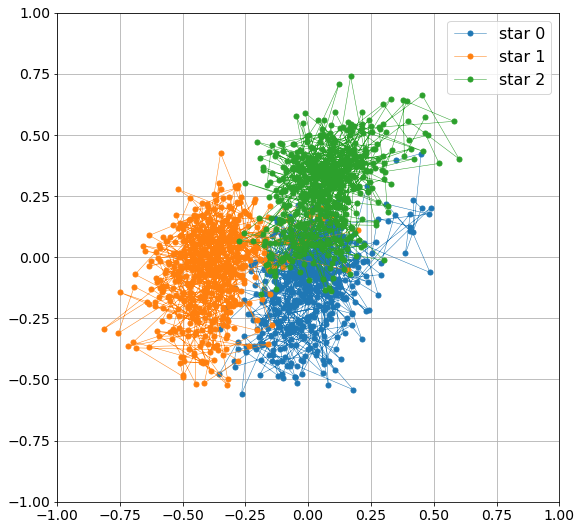

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(robot.stars)):
    y = data['p'][2 * i, :]
    z = data['p'][2 * i + 1, :]
    ax.plot(-y, z, label=f'star {i}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)

**Plotting State - Roll, Pitch, Yaw**

The following code block plots both true and estimated roll, pitch, and yaw for the single simulation above.

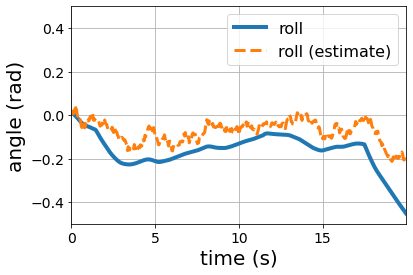

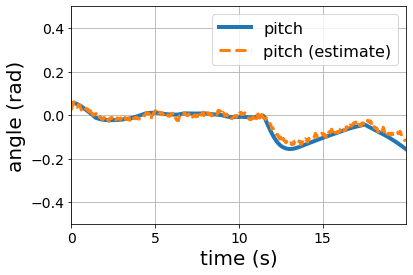

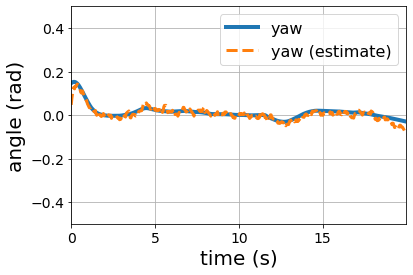

In [18]:
plt.plot(data['t'], data['rpy'][0, :], label='roll', linewidth=4)
plt.plot(data['t'], data['xhat'][0, :], '--', label='roll (estimate)', linewidth=3)
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('angle (rad)', fontsize=20)
plt.xlim([data['t'][0], data['t'][-1]])
plt.ylim(-0.5, 0.5)
plt.show()

plt.plot(data['t'], data['rpy'][1, :], label='pitch', linewidth=4)
plt.plot(data['t'], data['xhat'][1, :], '--', label='pitch (estimate)', linewidth=3)
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('angle (rad)', fontsize=20)
plt.xlim([data['t'][0], data['t'][-1]])
plt.ylim(-0.5, 0.5)
plt.show()

plt.plot(data['t'], data['rpy'][2, :], label='yaw', linewidth=4)
plt.plot(data['t'], data['xhat'][2, :], '--', label='yaw (estimate)', linewidth=3)
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('angle (rad)', fontsize=20)
plt.xlim([data['t'][0], data['t'][-1]])
plt.ylim(-0.5, 0.5)
plt.show()

## Aggregate Data Collection

**Aggregate Simulation Loop**

The next code block runs a set number of simulations (as determined by ```count```) automatically and calculates mean squared error of roll, pitch, and yaw for each simulation, collecting this data for further analysis. The uncommented block calculates mean squared error between the true state and desired state (in this project, 0 rad for all angles). The commented block is intended for calculating mean squared error between the true and estimated states for each angle. It may be necessary to restart the kernel if another simulation instance is already running, especially GUI instances.

In [15]:
trials = []
count = 1000

# Create simulation instance
robot = ae353_spacecraft.RobotSimulator(display=False)

# Loop
for i in range(0, count):
    roll_mse = 0.
    pitch_mse = 0.
    yaw_mse = 0.
    robot.reset()
    controller.reset()
    run_time = 20.0
    num_steps = int(run_time/robot.dt)
    start_time = time.time()
    for step in range(num_steps):
        t = robot.dt * step
        p, v = robot.get_sensor_measurements()
        tau = controller.run(p, v)
        rpy, angvel = robot.get_rpy_and_angvel()
        xhat = controller.xhat.flatten()
        
        # Compare actual state to desired state
        roll_mse += (rpy[0] - 0) ** 2 / num_steps
        pitch_mse += (rpy[1] - 0) ** 2 / num_steps
        yaw_mse += (rpy[2] - 0) ** 2 / num_steps
        
#         # Compare actual state to estimated state
#         roll_mse += (rpy[0] - xhat[0]) ** 2 / num_steps
#         pitch_mse += (rpy[1] - xhat[1]) ** 2 / num_steps
#         yaw_mse += (rpy[2] - xhat[2]) ** 2 / num_steps
        
        robot.set_actuator_commands(tau)
        robot.step(t=(start_time + (robot.dt * (step + 1))))
    trials.append([roll_mse, pitch_mse, yaw_mse])
    print('Trial {}'.format(i + 1), end='\r')
trials = np.array(trials)
print('Data collection complete')

Data collection complete


**Histogram**

The following code block plots a shared histogram of the mean squared errors of roll, pitch, and yaw. Bars are color coded and correspond to each angle.


Roll - Max: 4.4928024697732605, Min: 0.000421379746400978, Mean: 0.3875932524997121, Median: 0.010659467980234984, StDev: 0.8591975229192328



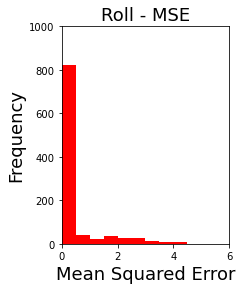


Pitch - Max: 0.7441466872246012, Min: 7.865900112135242e-05, Mean: 0.06550740510269397, Median: 0.002275661774603861, StDev: 0.14654924106642994



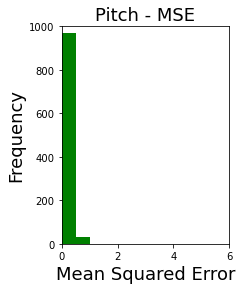


Yaw - Max: 5.069610220471767, Min: 3.256417567689914e-05, Mean: 0.3483823616884829, Median: 0.0012062748814669509, StDev: 0.9285581207660224



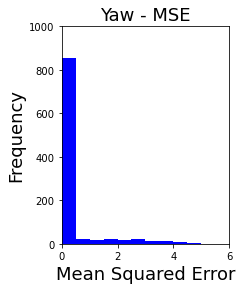

In [16]:
angles = ['Roll', 'Pitch', 'Yaw']
colors = ['r', 'g', 'b']
bins = np.linspace(0, 6, 13)
for i, angle in enumerate(trials.T):
    maximum = np.max(angle)
    minimum = np.min(angle)
    mean = np.mean(angle)
    median = np.median(angle)
    std = np.std(angle)
    print('\n{} - Max: {}, Min: {}, Mean: {}, Median: {}, StDev: {}\n'.format(angles[i], maximum, minimum, mean, median, std))
    plt.figure(figsize=(3,4))
    plt.hist(angle, bins=bins, color=colors[i])
    plt.title('{} - MSE'.format(angles[i], count), fontsize=18)
    plt.xlabel('Mean Squared Error', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xlim(0, 6)
    plt.ylim(0, 1000)
    plt.show()